In [380]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from keras.models import Sequential 
from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
import warnings
warnings.filterwarnings('ignore')

In [381]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed)

my_seed = 42
my_seed_everywhere(my_seed)

In [382]:
# data read
empty_emer = pd.read_csv('../DAT/empty_emer.csv',encoding = 'CP949')
empty_emer15 = empty_emer.loc[empty_emer.hospital_name=='철원병원'].copy()

empty_emer15.drop('hospital_name',axis=1, inplace = True)
empty_emer15 = empty_emer15.rename(columns={'available_bed_num':'available_bed_num',
                                             'record_time':'record_time'})
empty_emer15['record_time'] = pd.to_datetime(empty_emer15['record_time'], format = '%Y%m%d%H%M%S')
empty_emer15 = empty_emer15.set_index('record_time')
empty_emer15.head()

,available_bed_num
record_time,
2023-06-23 09:40:01,5
2023-06-23 09:50:02,5
2023-06-23 10:00:01,5
2023-06-23 10:10:01,5
2023-06-23 10:20:01,3


In [383]:
# data split
split_rate = 0.8
data = empty_emer15

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


In [384]:
train_data_len

541

In [385]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [386]:
# training 데이터의 samples 와 time steps로 원본데이터 슬라이싱하기
x_train = [] 
y_train = []  

time_steps = 6 
for_periods = 1

for i in range(time_steps, train_data_len - 1):
    x_train.append(train_data_scaled[i-time_steps:i].copy())
    y_train.append(train_data_scaled[i:i+for_periods].values[0][0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [387]:
i = 30
train_data[i:i+7]

,available_bed_num
record_time,
2023-06-23 15:00:01,5
2023-06-23 15:10:01,5
2023-06-23 15:20:01,5
2023-06-23 15:30:01,5
2023-06-23 15:40:01,4
2023-06-23 15:50:01,4
2023-06-23 16:00:01,4


In [388]:
x_train[i]

array([[1. ],
       [1. ],
       [1. ],
       [1. ],
       [0.8],
       [0.8]])

In [389]:
y_train[i]

0.8

In [390]:
x_train.shape

(534, 6, 1)

In [391]:
train_data_scaled.shape

(541, 1)

In [392]:
# 3차원으로 재구성하기
# np.reshape(samples, time steps, features) 로 만듦
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

# Preparing to creat X_test 
inputs = pd.concat((train_data_scaled, test_data_scaled), axis=0).values
inputs = inputs[len(inputs)-len(test_data_scaled) - time_steps:]
inputs = inputs.reshape(-1,1)

x_test = []
for i in range(time_steps, test_data_len + time_steps - for_periods):
    x_test.append(inputs[i-time_steps:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [393]:
# 3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
print('X_train 데이터프레임 형식으로 보기')
x_train_see = pd.DataFrame(np.reshape(x_train, (x_train.shape[0], x_train.shape[1])))
y_train_see = pd.DataFrame(y_train, columns = ['y_value'])
pd.concat([x_train_see, y_train_see], axis = 1).head()

X_train 데이터프레임 형식으로 보기


,0,1,2,3,4,5,y_value
0,1.00000,1.00000,1.00000,1.00000,0.60000,0.60000,0.60000
1,1.00000,1.00000,1.00000,0.60000,0.60000,0.60000,0.60000
2,1.00000,1.00000,0.60000,0.60000,0.60000,0.60000,0.60000
3,1.00000,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000
4,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000,0.20000


In [394]:
# 3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
x_test_see = pd.DataFrame(np.reshape(x_test, (x_test.shape[0], x_test.shape[1])))
pd.DataFrame(x_test_see).head()

,0,1,2,3,4,5
0,0.80000,0.80000,0.80000,1.00000,1.00000,1.00000
1,0.80000,0.80000,1.00000,1.00000,1.00000,1.00000
2,0.80000,1.00000,1.00000,1.00000,1.00000,1.00000
3,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
4,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [395]:
print("There are " + str(x_train.shape[0]) + " samples in the training data")
# There are 1505 samples in the training data

print("There are " + str(x_test.shape[0]) + " samples in the test data")
# There are 249 samples in the test data

There are 534 samples in the training data
There are 134 samples in the test data


GRU 모델 만들기

In [396]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
    actual_pred['available_bed_num'] = test_data[0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['available_bed_num']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

In [397]:
def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [437]:
def set_seed(SEED = 42):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [442]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 50, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'relu'))
my_GRU_model.add(GRU(units = 50, 
                     activation = 'relu'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                     momentum = 0.9, nesterov = False), 
                     loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 150, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 3ms/step


,test result,train result
MAE,0.52636,0.70727
RMSE,0.67671,0.93685
RMSLE,0.15612,0.31804
R2,0.47812,0.61249


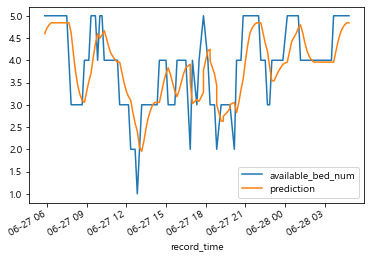

In [443]:
# GRU 결과 플롯 그리기
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

# 예측 성능 지표로 GRU 수행 결과 확인하기
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=test_data[0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)
test_result = confirm_result(y_test_gru, y_pred_gru)

train_pred_gru = pd.DataFrame(train_GRU_prediction[:, 0])
train_test_gru=train_data[0:len(train_GRU_prediction)]
train_test_gru.reset_index(drop=True, inplace=True)
train_result = confirm_result(train_test_gru, train_pred_gru)

test_result.columns = ['test result']
train_result.columns = ['train result']
total_result = pd.concat([test_result, train_result], axis = 1)
total_result